# SED fitting with naima

In this notebook we will carry out a fit of an IC model to the HESS spectrum of [RX J1713.7-3946](http://tevcat.uchicago.edu/?mode=1;id=84) with the naima wrapper around [emcee](http://dfm.io/emcee). This tutorial will follow loosely [the tutorial found on the naima documentation](http://naima.readthedocs.org/en/latest/tutorial.html).

The first step is to load the data, which we can find in the same directory as this notebook. The data format required by naima for the data files can be found [in the documentation](http://naima.readthedocs.org/en/latest/dataformat.html).

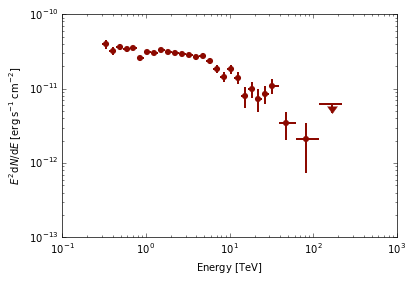

In [1]:
import naima
from astropy.io import ascii
import astropy.units as u
%matplotlib inline

hess_spectrum = ascii.read('RXJ1713_HESS_2007.dat', format='ipac')
fig = naima.plot_data(hess_spectrum)

The we define the model to be fit. The model function must take a tuple of free parameters as first argument and a data table as second. It must return the model flux at the energies given by `data['energy']` in first place, and any extra objects will be saved with the MCMC chain. 

`emcee` does not accept astropy Quantities as parameters, so we have to give them units before setting the attributes of the particle distribution function.

Here we define an IC model with an Exponential Cutoff Power-Law with the amplitude, index, and cutoff energy as free parameters. Because the amplitude and cutoff energy may be considered to have a uniform prior in log-space, we sample their decimal logarithms. We also place a uniform prior on the particle index with limits between -1 and 5.

In [15]:
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
from naima import uniform_prior

ECPL = ExponentialCutoffPowerLaw(1e36/u.eV, 3*u.TeV, 2.7, 50*u.TeV)
IC = InverseCompton(ECPL, seed_photon_fields=['CMB', ['FIR', 30*u.K, 0.4*u.eV/u.cm**3]])

# define labels and initial vector for the parameters
labels = ['log10(norm)', 'index', 'log10(cutoff)']
p0 = np.array((34, 2.7, np.log10(30)))

# define the model function
def model(pars, data):
    ECPL.amplitude = (10**pars[0]) / u.eV
    ECPL.alpha = pars[1]
    ECPL.e_cutoff = (10**pars[2]) * u.TeV

    return IC.flux(data['energy'], distance=2.0*u.kpc), IC.compute_We(Eemin=1*u.TeV)

from naima import uniform_prior

def lnprior(pars):
    lnprior = uniform_prior(pars[1], -1, 5)
    return lnprior

We take the data, model, prior, parameter vector, and labels and call the main fitting procedure: `naima.run_sampler`. This function is a wrapper around `emcee`, and the details of the MCMC run can be configured through its arguments:

- `nwalkers`: number of emcee walkers.
- `nburn`: number of steps to take for the burn-in period. These steps will be discarded in the final results.
- `nrun`: number of steps to take and save to the sampler chain.
- `prefit`: whether to do a Nelder-Mead fit before starting the MCMC run (reduces the burn-in steps required).
- `interactive`: whether to launch an interactive model fitter before starting the run to set the initial vector. This will only work in matplotlib is using a GUI backend (qt4, qt5, gtkagg, tkagg, etc.). The final parameters when you close the window will be used as starting point for the run.
- `threads`: How many different threads (CPU cores) to use when computing the likelihood.

In [ ]:
sampler, pos = naima.run_sampler(data_table=hess_spectrum, model=model, prior=lnprior, p0=p0, labels=labels,
                                nwalkers=32, nburn=50, nrun=100, prefit=True, threads=4)

INFO:astropy:Finding Maximum Likelihood parameters through Nelder-Mead fitting...
INFO:astropy:   Initial parameters: [ 34.30575107   2.7          1.47712125]
INFO:astropy:   Initial lnprob(p0): -79.129


INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [ 34.30575107   2.7          1.47712125] [naima.core]
INFO:    Initial lnprob(p0): -79.129 [naima.core]
INFO

INFO:astropy:   New ML parameters : [ 34.10228321   2.57130096   1.69315145]
INFO:astropy:   Maximum lnprob(p0): -17.991


:    New ML parameters : [ 34.10228321   2.57130096   1.69315145] [naima.core]
INFO:    Maximum lnprob(p0): -17.991 [naima.core]
Burning in the 32 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      34.1            2.57            1.69      
  Last ensemble std    :      0.165          0.0113          0.00718    
  Last ensemble lnprob :  avg: -318.489, max: -19.014

Progress of the run: 10 percent (5 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      34.1            2.57            1.69      
  Last ensemble std    :      0.116          0.0127          0.0113     
  Last ensemble lnprob :  avg: -181.611, max: -17.987

Progress of the run: 20 percent (10 of 50 steps)
                           --log10(norm)-- -----index----- -log10(cutoff)-
  Last ensemble median :      34.1            2.57      

INFO:astropy:-------------------log10(norm)--------------------
          log10(norm) = $32.75^{+0.03}_{-0.02}$
                 norm = $(5.7^{+0.5}_{-0.3})\times10^{32}$


INFO: -------------------log10(norm)--------------------
          log10(norm) = $32.75^{+0.03}_{-0.02}$
                 norm = $(5.7^{+0.5}_{-0.3})\times10^{32}$ [naima.plot]
INFO

INFO:astropy:----------------------index-----------------------
          index = $2.56 \pm 0.11$


: ----------------------index-----------------------
          index = $2.56 \pm 0.11$ [naima.plot]
INFO

INFO:astropy:------------------log10(cutoff)-------------------
          log10(cutoff) = $1.70^{+0.09}_{-0.12}$
                 cutoff = $51 \pm 12$


: ------------------log10(cutoff)-------------------
          log10(cutoff) = $1.70^{+0.09}_{-0.12}$
                 cutoff = $51 \pm 12$ [naima.plot]


/home/vzabalza/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


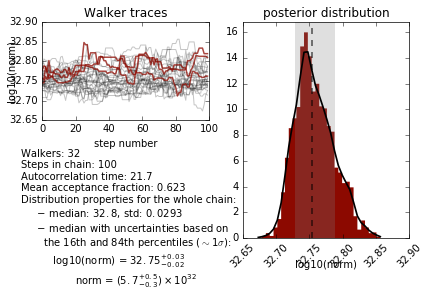

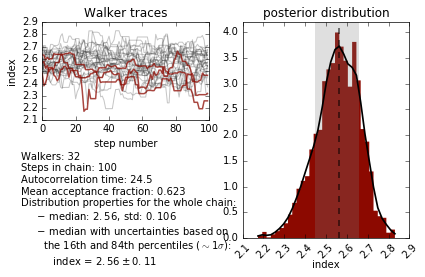

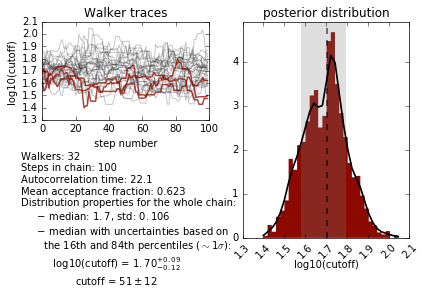

In [4]:
# inspect the chains stored in the sampler for the three free parameters
f = naima.plot_chain(sampler, 0)
f = naima.plot_chain(sampler, 1)
f = naima.plot_chain(sampler, 2)

In [ ]:
# make a corner plot of the parameters to show covariances
f = naima.plot_corner(sampler)

(1e-13, 1e-10)

/home/vzabalza/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


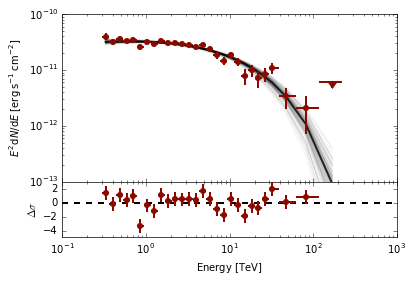

In [6]:
# Show the fit
f = naima.plot_fit(sampler)
f.axes[0].set_ylim(bottom=1e-13)

/home/vzabalza/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


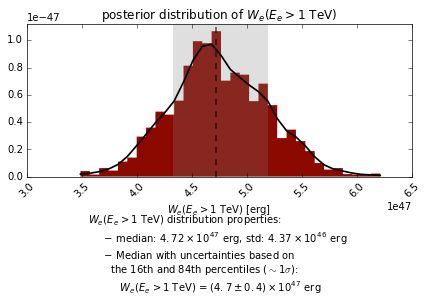

In [7]:
# Inspect the metadata blob saved
f = naima.plot_blob(sampler,1, label='$W_e (E_e>1$ TeV)')

INFO:astropy:Plotting chain of parameter log10(norm)...


INFO: Plotting chain of parameter log10(norm)... [naima.analysis]
INFO

INFO:astropy:-------------------log10(norm)--------------------
          log10(norm) = $32.75^{+0.03}_{-0.02}$
                 norm = $(5.7^{+0.5}_{-0.3})\times10^{32}$


: -------------------log10(norm)--------------------
          log10(norm) = $32.75^{+0.03}_{-0.02}$
                 norm = $(5.7^{+0.5}_{-0.3})\times10^{32}$ [naima.plot]
INFO

/home/vzabalza/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
INFO:astropy:Plotting chain of parameter index...


: Plotting chain of parameter index... [naima.analysis]
INFO

INFO:astropy:----------------------index-----------------------
          index = $2.56 \pm 0.11$


: ----------------------index-----------------------
          index = $2.56 \pm 0.11$ [naima.plot]
INFO

INFO:astropy:Plotting chain of parameter log10(cutoff)...


: Plotting chain of parameter log10(cutoff)... [naima.analysis]
INFO

INFO:astropy:------------------log10(cutoff)-------------------
          log10(cutoff) = $1.70^{+0.09}_{-0.12}$
                 cutoff = $51 \pm 12$


: ------------------log10(cutoff)-------------------
          log10(cutoff) = $1.70^{+0.09}_{-0.12}$
                 cutoff = $51 \pm 12$ [naima.plot]
INFO

INFO:astropy:Plotting corner plot...


: Plotting corner plot... [naima.analysis]
INFO

INFO:astropy:Plotting Spectrum...


: Plotting Spectrum... [naima.analysis]
INFO

INFO:astropy:Plotting $W_e (E_e>1$ TeV)...


: Plotting $W_e (E_e>1$ TeV)... [naima.analysis]


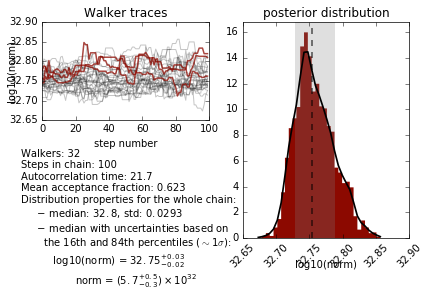

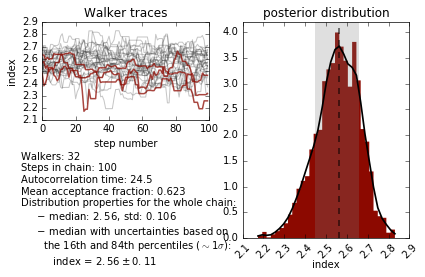

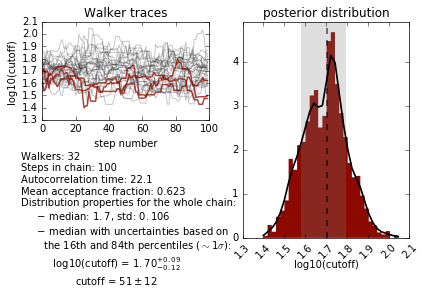

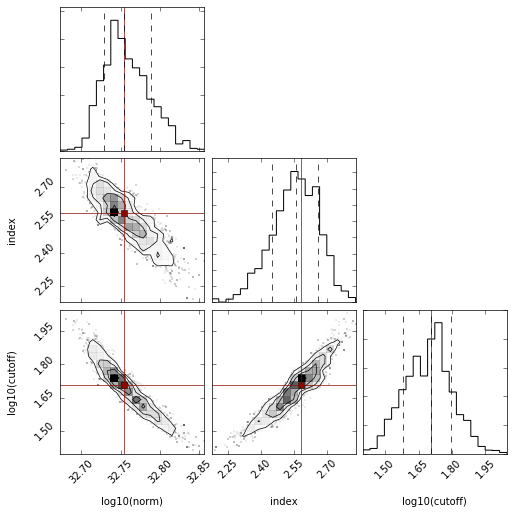

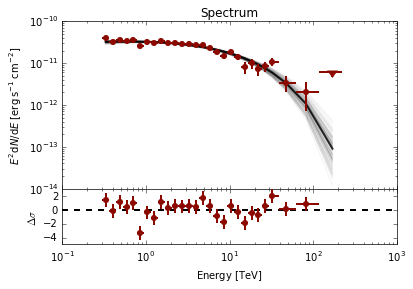

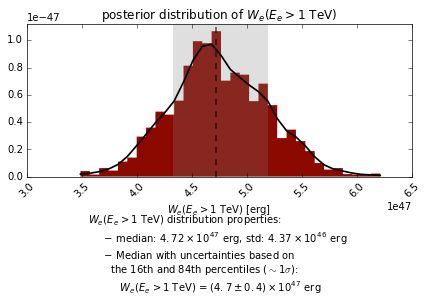

In [8]:
# There is also a convenience function that will plot all the above files to pngs or a single pdf
naima.save_diagnostic_plots('RXJ1713_naima_fit', sampler, blob_labels=['Spectrum','$W_e (E_e>1$ TeV)'])

# Simultaneous fitting of two radiative components: Synchrotron and IC. 

Use the Suzaku XIS spectrum of RX J1713 to do a simultaneous fit of the synchrotron and inverse Compton spectra and derive an estimate of the magnetic field strength under the assumption of a leptonic scenario.

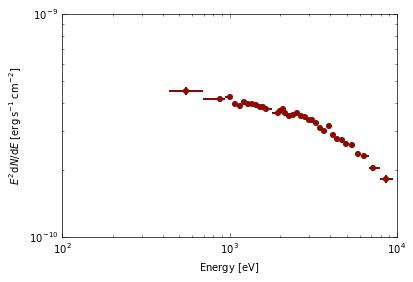

In [9]:
suzaku_spectrum = ascii.read('RXJ1713_Suzaku-XIS.dat')
f=naima.plot_data(suzaku_spectrum)

Note that in all naima functions (including `run_sampler`) you can provide a list of spectra, so you can consider both the HESS and Suzaku spectra:

/home/vzabalza/.local/lib/python3.4/site-packages/naima/plot.py:827: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 36
  (data['flux'][notul] * sedf[notul]).to(f_unit).value,
/home/vzabalza/.local/lib/python3.4/site-packages/naima/plot.py:828: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 36
  yerr=(yerr * sedf[notul]).to(f_unit).value,
/home/vzabalza/.local/lib/python3.4/site-packages/naima/plot.py:827: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolean dimension is 28
  (data['flux'][notul] * sedf[notul]).to(f_unit).value,
/home/vzabalza/.local/lib/python3.4/site-packages/naima/plot.py:828: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 64 but corresponding boolea

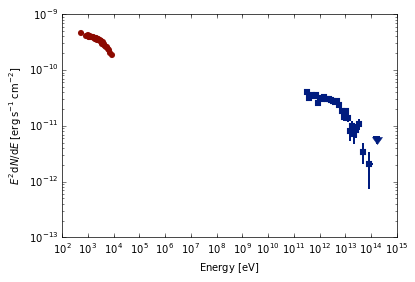

In [10]:
f=naima.plot_data([suzaku_spectrum, hess_spectrum], sed=True)

Below is the model, labels, parameters and prior defined above for the IC-only fit. Modify it as needed and feed it to `naima.run_sampler` to obtain an estimate of the magnetic field strength.

In [11]:
#from naima.models import ExponentialCutoffPowerLaw, InverseCompton
#from naima import uniform_prior

#ECPL = ExponentialCutoffPowerLaw(1e36/u.eV, 10*u.TeV, 2.7, 50*u.TeV)
#IC = InverseCompton(ECPL, seed_photon_fields=['CMB', ['FIR', 30*u.K, 0.4*u.eV/u.cm**3]])

## define labels and initial vector for the parameters
#labels = ['log10(norm)', 'index', 'log10(cutoff)']
#p0 = np.array((34, 2.7, np.log10(30)))

## define the model function
#def model(pars, data):
#    ECPL.amplitude = (10**pars[0]) / u.eV
#    ECPL.alpha = pars[1]
#    ECPL.e_cutoff = (10**pars[2]) * u.TeV

#    return IC.flux(data['energy'], distance=2.0*u.kpc), IC.compute_We(Eemin=1*u.TeV)

#from naima import uniform_prior

#def lnprior(pars):
#    lnprior = uniform_prior(pars[1], -1, 5)
#    return lnprior